# **Lab 8**


## Building Predictive Models (Regression & Classification)

In this lab, you will learn the basic pipeline of how to build predictive models. The process of training models from data is part of a machine learning where we use lots of data to enable the machine (that is, computers) to learn models that eventually, can be deployed to make further predictions on new or unseen data. Basically, this automates the process of making manual predictions either through a subject matter expert, or through rules and heuristics decided by the expert. 

> **Credit note:** A small portion of this lab was adapted from [Aurelien Geron's tutorial](https://github.com/ageron/handson-ml). You can find a lot of comprehensive tutorials there.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

We will be using `scikit-learn`, a very popular machine learning (ML) library for Python. 

> **Note**: scikit-learn has very rapid development (every few months, there's an upgrade in version), so you can constantly check to see if the updated version is available.

In [ ]:
!pip install --upgrade scikit-learn

Let's try examining a substantially large dataset, `california_housing.csv` which consists of housing data from the state of California in USA. There's more than 20,000 rows of data and this would be more than sufficient for training predictive models.

In [ ]:
df = pd.read_csv('california_housing.csv', encoding='latin1')

In [ ]:
df.head()

Let's have a look at the information of this dataset...

In [ ]:
df.info()

We have all numerical data except for the last column `ocean_proximity` which is stated as *object*. A closer look at the values of this attribute will reveal that they are actually strings. 

> **Recall:** When using dataframes, strings are also considered objects.

In [ ]:
df['ocean_proximity'].head()

### Preparing the data for model training

Before we train the model, we need to prepare the data by doing a few things:
* Are there any rows with null values?
* Are there any attributes that are categorical? If yes, and if we are planning to use it to train the model, we ought to convert it to discrete numerical values.
* Separate out the descriptor (features) and the response (label) data.

In [ ]:
sample_incomplete_rows = df[df.isnull().any(axis=1)]     # filter out rows with null values on any column
sample_incomplete_rows

We have 207 rows containing null values on the `total_bedrooms` column. We have a two quick options: 1) Have these rows removed (if there not many, it would not affect the overall size of the data), 2) Fill these null values with the mean or median value.

In [ ]:
# option 1 (remove these rows)

# check these 2 columns that are likely to have NaNs
housing = df.dropna(subset=["total_bedrooms",'ocean_proximity'],axis=0)  
housing.reset_index(drop=True)

In [ ]:
len(housing)

In [ ]:
# [OPTIONAL] Option 2: fill with mean or median value. This can be tried later.


`ocean_promixity` attribute contained a discrete number of categories. In certain libraries that you will be training a model, you may not need to convert its form (discrete categories is accepted), but most cases including for `scikit-learn` package, we need to convert them into numerics. scikit-learn has a `LabelEncoder` class which does the job.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"].values
housing_cat_encoded = encoder.fit_transform(housing_cat.astype('str'))   # this "fits" the labels to numerical classes
housing_cat_encoded

In [ ]:
encoder.classes_

To make this change directly to the dataframe, replace the original strings with the encoded numerics.

In [ ]:
housing['ocean_proximity'] = encoder.fit_transform(housing['ocean_proximity'])

In [11]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1


In supervised machine learning, we have the "data" and the "labels" the so-called "descriptor" and the "response" variables respectively. `scikit-learn` (and many other packages) uses the `X` and `y` variables as conventions:

In [12]:
X = housing.drop("median_house_value", axis=1)     # drop labels from original data
y = housing["median_house_value"].copy()    # copy the labels to another dataframe/series

In [20]:
# checking the shape is a good practice to know that the information is correct
print(X.shape)
print(y.shape)

(20433, 9)
(20433,)


### Model Training

#### Training and Test sets

The first step before performing model training is to first divide our data into 2 partitions: **training** and **test** sets. The training set is basically the portion of data that is used to build the model. This set is not appropriate to be used to evaluate the actual performance of the model. Hence, that's why we need the test set. The test set is a held-out portion of the data which will be used to measure how well can the model predict unseen data. Now, obviously all the data we have are "seen", but we create an environment where there are "unseen" data-- data that has not been seen by the machine during the training step. This can give us an idea how well does the model generalizes towards "new" data.


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

By default, `train_test_split` splits the data in *X* into the train and test portion based on the parameter `test_size=0.25` or 25% of samples in the test size and the remaining (75%) of samples in the training set. This gives a training-test ratio of 3:1. The `random_state` parameter takes a seed value so that the splitting will always be the same (for reproducibility purposes in this exercise). It is OK to leave out this parameter, which in that case, produces totally random splits in every execution.

In [15]:
# check shapes after splitting
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15324, 9)
(15324,)
(5109, 9)
(5109,)


The prediction of median house value has an expected response in a form of a continuous value, not as categories or classes. It is a **regression** problem, which means that, given a bunch of new data (*X'*), we want to estimate the likely house value (*y'*).

Let's go with the simplest method: **Linear Regression**. (And later, we shall also use Decision Tree Regressors to try out).

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# this fits the data to a linear regression model. This should be extremely quick!
reg = LinearRegression().fit(X_train, y_train)

If you are interested to know what are the *coefficients* to the linear regression model that has been found through the training process:

In [18]:
reg.coef_

array([-4.27859586e+04, -4.25579406e+04,  1.16899780e+03, -8.25110417e+00,
        1.15446438e+02, -3.69104753e+01,  4.31167826e+01,  4.02676934e+04,
        1.31708435e+02])

In [19]:
reg.intercept_

-3591367.637135243

**Q1**: What can you understand from these values? Can you figure out what is the linear function that has been fitted to the data?

<br>re.coef_ gives us the 9 slopes for each pair of data and labels. For example look at the third data, a 1 unit change in the housing median age, the median price will increacse for about 1.169 unit. reg.intercept is the yintercept of the regression line, which is smoetimes called the A<br>

The function `score()` returns the $\text{R}^2$ determination coefficient which measures how well is the fitting. 1.0 gets us a perfect fit while -1.0 gets us the poorest fit, any value around 0.0 basically means the model predicts something disregarding the input features, which is as good as random. (Note: this seems like similar range to correlation, but it is not correlation!)

In [31]:
reg.score(X_test, y_test)

0.6480945215253389

Let's take the first 5 entries from the test data and use the model to make predictions on the house value. The `predict()` function can perform prediction on a single piece of data, or an array of data.

In [32]:
some_data = X_test.iloc[:5]    # take first 5 entries from X_test
predicted_house_values = reg.predict(some_data)
predicted_house_values

array([376549.98172671, 273367.48120465, 146586.82021588, 357596.93640995,
        29098.29218556])

In [33]:
actual_house_values = y_test.iloc[:5].values     # here's the first 5 entries from y_test, which are the 'ground truth'
actual_house_values

array([360900., 291500., 131300., 500001., 118800.])

How far are the predicted house values compared to the actual house values? Remember, we have the 'ground truth' or the actual answer. 

Let's do a simple error calculation. How about finding the *absolute difference* between the two sets of values?

In [35]:
np.abs(predicted_house_values-actual_house_values)

array([ 15649.98172671,  18132.51879535,  15286.82021588, 142404.06359005,
        89701.70781444])

**What do you observe?**

To calculate the mean of this error across all test data, we calculate what is known as **Mean Absolute Erorr (MAE)**, which tells us the amount of error made by the trained model. The *lower* this value, the *better* or more *accurate* the model is.

In [36]:
from sklearn.metrics import mean_absolute_error

y_pred = reg.predict(X_test)
model_mae = mean_absolute_error(y_test, y_pred)
print(model_mae)

50796.156942570015


Let's try to do some plotting to see where are the data points are and where the linear model is. You can attempt to plot the line manually using the coefficients and intercept values from the model fitting. 

You can also use seaborn's `regplot()` function which does both: linear regression + plotting the scatter and regression line. The only drawback here is that it does not return the model parameters (coefficients and intercept), hence limiting your ability to use the model for further predictions. 

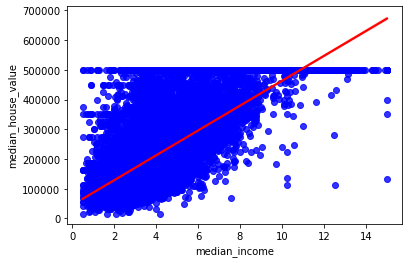

In [37]:
sns.regplot(x="median_income", y="median_house_value", data=housing, 
            scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.show()

Now, let's re-run our experiment using **Decision Tree Regressors**, another regression method that is based on decision trees.

In [38]:
from sklearn.tree import DecisionTreeRegressor

In [39]:
dtr1 = DecisionTreeRegressor(max_depth=7)
dtr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=7)

**Technical note:** `max_depth` controls the maximum possible depth of the decision tree (that means, the decision tree cannot expand deeper than this value). The deeper a decision tree expands, the finer it splits the data. This can increase the complexity of the model by way of many local linear regressions, but at the expense of overfitting the training data too much.

In [40]:
y_pred2 = dtr1.predict(X_test)
dtr1_mae = mean_absolute_error(y_test, y_pred2)
dtr1_mae

43226.096007614375

**Q2**: Find out what is the best `max_depth` parameter such that we can have the smallest MAE score. 

Hint: Try plotting `max_depth` vs. MAE. Is there a "sweet spot" that we can get the best result?

In [46]:
dtrlist=[]
max_depth_list = [range(1,100)]
for i in max_depth_list:
    dtr = DecisionTreeRegressor(max_depth=i)
    dtr.fit(X_train,y_train)
    ypred = dtr.predict(X_test)
    dtr_mae = mean_absolute_error(y_test,ypred)
    dtrlist.append(dtr_mae)
dtrlist

[74634.75355691169,
 65526.49237260166,
 60763.045695331726,
 53624.31076107762,
 50442.835199054294,
 46248.91465712863,
 43211.49743735611,
 41537.78904075618,
 39769.9287047663,
 39356.17727507083,
 39074.526819182924,
 39430.72519720961,
 39553.38628495353,
 40072.19921911557,
 41037.45891691596,
 41424.408133367746,
 41606.18757838359,
 42137.395635789995,
 42044.07999851207,
 42815.77344037427,
 43226.78635013043,
 42962.543511720585,
 42815.13154932482,
 42526.2733621605,
 42653.842702957205,
 42882.9220571376,
 43113.92248494421,
 43144.2985890276,
 43138.14327657076,
 43370.37698179683,
 42711.3725451817,
 43422.10138970445,
 42578.649833626936,
 43018.364063417495,
 42875.437854766096,
 43382.05402231356,
 42945.88432178509,
 43112.47308670973,
 42696.18809943237,
 42878.90213348992,
 43033.57232335095,
 42835.274417694265,
 43506.326286944604,
 42843.220395380704,
 43473.28870620474,
 42907.48228616168,
 42886.94813074966,
 43284.601291837935,
 43018.93149344294,
 43187.7909

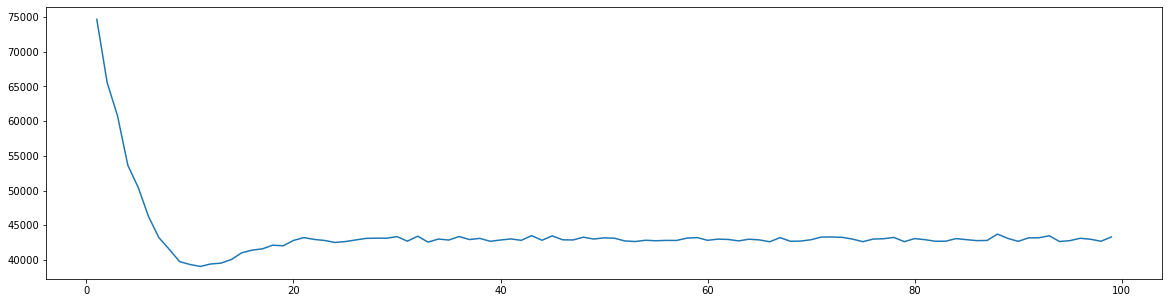

In [55]:
import matplotlib.pyplot as plt
max_depth_list = range(1,100)
plt.figure(figsize=(20,5))
plt.plot(max_depth_list, dtrlist)

It seems like the MAE start to stabilize when the depth value is around 17.

### Cross-Validation

You may be wondering, isn't this setup a bit unfair, since we have split the data into two portions, 75% for training and 25% for testing. That means the other 75% that were used for training never got chance to be tested. This can be unfair: Either we got really lucky having good results with that 25% data, or we were unlucky having bad results that some better results could be possible if we had split the portions differently. 

In comes **cross-validation**. Cross-validation is a way of ensuring that every sample gets tested at least once. The way to achieve this is by having a "folding" mechanism that will run a few iterations going through a few possible splits. For example, if we intend to perform cross-validation with 3 "folds" (also known as 3-fold cross-validation), we first need to partition the full set of data into 3 sections. The 1st section is then held-out as the test set, while the 2nd and 3rd sections will be merged and used as the training set. This is then repeated again by holding out the 2nd section and using the 1st and 3rd sections as training. Finally, repeat again one more time with the 3rd section as test set. We will have 3 test scores in the end. Typically, we will take the average score of all folds as the actual overall score.

In [56]:
from sklearn.model_selection import cross_validate

In [57]:
regmodel = LinearRegression()
cv_results = cross_validate(regmodel, X, y, cv=3, return_train_score=False)

In [58]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

In [59]:
cv_results['test_score']

array([0.57872609, 0.62030172, 0.6025268 ])

In [60]:
cv_results['test_score'].mean()

0.6005182065566624

In [78]:
from sklearn.metrics import make_scorer
mae_scorer = make_scorer(mean_absolute_error)
cv_results = cross_validate(regmodel, X, y, cv=3, scoring=mae_scorer, return_train_score=False)
print(cv_results['test_score'])
cv_results['test_score'].mean()

[56689.14499557 48747.76068534 54790.16740463]


53409.02436184533

So, there you go, we now have slightly lower $\text{R}^2$ results, and slightly higher MAE than before, after we did a thorough cross-validation so that all data samples were tested at least once.

You may check out the the list of [linear models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) in scikit-learn (some for regression, some for classification). Other popular choices for regression are Ridge, Lasso and ElasticNet.

### Classification

Let's use the dataset again for the purpose of classification.

A Question you would ask could be like: 

Can we predict the proximity of a house to the ocean given that we know the other attributes (such as median house value, median income, number of bedrooms, etc.) ?

In [ ]:
housing['ocean_proximity'].value_counts()

We have 5 entries (label 2) which corresponds to 'ISLAND'. Perhaps there's not many housing on the islands of the Californian coast. We will not be able to build any model to predict this category with so little data. Let's discard it.

In [ ]:
housing3 = housing[housing['ocean_proximity']!=2]

In [ ]:
housing3['ocean_proximity'].value_counts()

If you intend to transform back the numerical categories to get the actual discrete categories, you can use `inverse_transform` of the `LabelEncoder` we created earlier. Otherwise, it is fine to leave it as numerical categories.

In [ ]:
# use the label encoder created earlier to transform backwards these numbers to get the actual labels
encoder.inverse_transform(housing3['ocean_proximity'].unique())

Let's now form a new bunch of variables (XX) and response (yy) according to this classification problem.

In [ ]:
XX = housing3.drop("ocean_proximity", axis=1)     # drop labels from original data
yy = housing3["ocean_proximity"].copy()    # copy the labels to another dataframe/series

In [ ]:
from sklearn.linear_model import LogisticRegression

Our choice of classification algorithm is the **Logistic Regression**. The logistic regression is fundamentally derived from regression models, but due to the nature of using a *logistic function*, it functions like a classifier, giving almost binary decisions (close to 1 or 0) to predictions. So, this makes it more a classifier than a regressor.

In [ ]:
lr_model = LogisticRegression()

In [ ]:
cv_model = cross_validate(lr_model, XX, yy, cv=3, return_estimator=True, return_train_score=True, verbose=2)

In [74]:
cv_model

{'fit_time': array([0.57155275, 0.57927513, 0.59656286]),
 'score_time': array([0.00412846, 0.00431895, 0.00311375]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_score': array([0.53010279, 0.52386547, 0.53238361]),
 'train_score': array([0.52048759, 0.51097731, 0.56046699])}

In [75]:
print(cv_model['train_score'])
print(cv_model['train_score'].mean())
print(cv_model['test_score'])
print(cv_model['test_score'].mean())

[0.52048759 0.51097731 0.56046699]
0.5306439652345976
[0.53010279 0.52386547 0.53238361]
0.5287839573706362


Note that there is no mention what this "score" is but it depends on the algorithm used. Since we are using a classifier, it is likely to be an Accuracy metric by default, but of course the scorer is customizable as we saw earlier. If unsure, go to [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) and check out the documentation.

**How well did the logistic regression classifier perform?**

We got an accuracy of ~52% (this varies since we did not use a fixed seed to split the data). Since this is a 4-category classification, we are expecting a random prediction of 25%. So our accuracy is not too bad for a start! 

Notice also how the training score is higher than the test score. This is a common occurrence when doing machine learning. Typically, the trained model will fit better onto the training data (because it is seen anyway), and when applied to unseen test data, it will generally perform less accurately.

To pick the best estimator, we can simply look at the 3 models from the 3 folds and take the one which gave the best test score. Modify accordingly.

In [77]:
cv_model['estimator'][2]  # 2 is the index for the third fold's model, return the Logistic Regression object corresponding to the index

LogisticRegression()

Now this model can now be deployed to classify future data that will be collected.

You may try a few other things:

**Q3**:
Use other classifiers to see if you can improve on the classification performance. Here are some options:  [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [`SVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [`MultiLayer Perceptron (MLP)`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). The workflow is the same, with only the change in algorithm.


In [85]:
from sklearn.neighbors import KNeighborsClassifier

Xknc = housing3.drop("ocean_proximity", axis=1)     # drop labels from original data
yknc = housing3["ocean_proximity"].copy()    # copy the labels to another dataframe/series

knc_model = KNeighborsClassifier(n_neighbors=3)
knc_cv_model = cross_validate(knc_model, Xknc, yknc, cv=3, return_estimator=True, return_train_score=True, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s finished


{'fit_time': array([0.02552485, 0.0290885 , 0.0236671 ]),
 'score_time': array([0.41387749, 0.37885356, 0.32534003]),
 'estimator': [KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=3)],
 'test_score': array([0.57562408, 0.5505948 , 0.57512116]),
 'train_score': array([0.73718608, 0.73786622, 0.73353403])}

In [86]:
knc_cv_model

{'fit_time': array([0.02552485, 0.0290885 , 0.0236671 ]),
 'score_time': array([0.41387749, 0.37885356, 0.32534003]),
 'estimator': [KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=3)],
 'test_score': array([0.57562408, 0.5505948 , 0.57512116]),
 'train_score': array([0.73718608, 0.73786622, 0.73353403])}

**Q4**:
Perform classification (without cross-validation) and display the confusion matrix (Hint: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function or [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) for a nicer visualization). From the confusion matrix, you will get to see which classes are performing well and which are not.

In [27]:
# I use logistic regression as the classification algorithm
from sklearn import metrics
lr_model2 = LogisticRegression()
XX2 = housing3.drop("ocean_proximity", axis=1)     # drop labels from original data
yy2 = housing3["ocean_proximity"].copy()    # copy the labels to another dataframe/series


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XX2, yy2, random_state=1)
lr_model2.fit(X_train,y_train)
print("babi")

### "Pickle" it

You can save the model in scikit-learn using Python's built-in persistence model, called `pickle`. Think of how food can be preserved by the 'pickling' process. :)

In [ ]:
import pickle

best_model = cv_model['estimator'][2]

with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Check your directory (or you can just click on the folder icon in Colab) to see if the pickle file has been created. It's just a little over 1KB, very small!

In [ ]:
!dir

In [ ]:
del best_model

When you need to load the model:

In [ ]:
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file, encoding='bytes')

In [ ]:
loaded_model.coef_

## **Additional Task 1: Grid Search**

Some algorithms have many "free parameters" that can be tuned to get better models. For example, the [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) or Linear Support Vector Classifier has parameters like the `loss`, `penalty`, `C`, etc. which can influence how the model is fitted. So, in order to fully test which parameter, or combination of parameters works the best for your data, you can use `GridSearchCV` (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)) which searches through all possible combinations of the parameters from a defined list of values.

In [ ]:
from sklearn.model_selection import GridSearchCV

svc = LogisticRegression(random_state=0)
parameters = {'penalty':('l1','l2'), 'C':[0.1, 1, 10, 100, 1000]}   # define the parameters and their value sets
clf = GridSearchCV(svc, parameters, verbose=2)
clf.fit(XX, yy)

To obtain the best fitted model, use `best_estimator_` function. To obtain all cross validated results, use `cv_results_`

In [ ]:
clf.best_estimator_

In [ ]:
clf.best_params_

In [ ]:
clf.cv_results_

## **Additional Task 2: Spyder**

With many overlapping lines of code in Jupyter, sometimes you may prefer to put all the essential code (minus away all those that are usually for testing purposes) into a .py file. Spyder is an IDE that comes with Anaconda and you can use it to run your .py file or even larger projects with multiple files. 